In [19]:
import pandas as pd
import vector
import numpy as np
import matplotlib.pyplot as plt  
from bs4 import BeautifulSoup
from particle import Particle
from scipy.optimize import curve_fit
from scipy.stats import chi2, chisquare
from scipy.stats import linregress
from scipy.interpolate import interp1d
import mplhep as hep
from matplotlib.lines import Line2D

from matplotlib.patches import Rectangle


In [20]:
# Constantes fornecidas
alpha = 1 / 137  # Constante de estrutura fina
mu = 0.10566  # Massa do múon em GeV
GeV_to_pb = 3.894*1e8
pi = np.pi

M_Z = 91.18  # Massa do bóson Z em GeV
erro_mz = 0.0020

Gamma_Z = 2.4955 # Largura de decaimento total do bóson Z em GeV
erro_gamma_z = 0.0023

Gamma_ee = 0.083984  # Largura de decaimento do Z para ee em GeV
Gamma_mumu = 0.083984  # Largura de decaimento do Z para μμ em GeV

m_e = 0.000511  


In [21]:
#====================================================================================
# Função de seção de choque Breit-wegner
def weak(s):
     return (12 * np.pi * s**2 * Gamma_ee * Gamma_mumu) / (M_Z**2 * ((s**2 - M_Z**2)**2 + M_Z**2 * (Gamma_Z**2)))
#====================================================================================
# função da seção de choque fóton    
def qed(s):
    return (4 * pi * alpha**2 / 3) / s**2
#====================================================================================
# Função de seção de choque Breit-wegner
def total(s):
    return (12 * np.pi * s**2 * Gamma_ee * Gamma_mumu) / (M_Z**2 * ((s**2 - M_Z**2)**2 + M_Z**2 * (Gamma_Z**2))) + (4 * pi * alpha**2 / 3) / s**2



In [22]:
def extrair_arrays(html_file):
    # Carregar o conteúdo do arquivo HTML
    with open(html_file, 'r') as file:
        soup = BeautifulSoup(file, 'html.parser')
    
    energias = []
    secoes_de_choque = []
    erros_associados = []
    
    # Procurar todas as linhas que contêm as informações necessárias
    rows = soup.find_all('tr')

    for row in rows:
        cells = row.find_all('td')
        
        if len(cells) >= 4:  # Certificando que a linha tenha células suficientes
            collider_info = cells[1].get_text(strip=True)
            cross_section_info = cells[3].get_text(strip=True)
            
            # Extraindo a energia de centro de massa
            try:
                # Removendo "e+ e-" e espaços extras, isolando a parte numérica
                energia = collider_info.replace('e+ e-', '').replace('GeV', '').strip()
                energia1, energia2 = [float(e) for e in energia.split('x')]
                energia_centro_massa = energia1 + energia2
                energias.append(energia_centro_massa)
            except ValueError:
                print(f"Erro ao converter energia para float em {collider_info}")
                continue
            
            # Extraindo a seção de choque e o erro associado
            try:
                cross_section, error = cross_section_info.split('±')
                cross_section = float(cross_section.strip())
                error = float(error.strip())
                secoes_de_choque.append(cross_section)
                erros_associados.append(error)
            except ValueError:
                print(f"Erro ao processar seção de choque ou erro em {cross_section_info}")
                continue
    
    return energias, secoes_de_choque, erros_associados



html_file='geracao_tcc.html'

energias, secoes_de_choque, erros_associados = extrair_arrays(html_file)

energias = np.array(energias)
secoes_de_choque=np.array(secoes_de_choque)
erros_associados= np.array(erros_associados)



# Exibindo os arrays
#print("Energias:", energias)
#print("Seções de Choque:", secoes_de_choque)
#print("Erros Associados:", erros_associados)


In [23]:
teoria_fraca = weak(energias)*GeV_to_pb
teoria_qed = qed(energias)*GeV_to_pb
teoria_total = total(energias)*GeV_to_pb

razao_fraca = (teoria_fraca/secoes_de_choque)**-1
razao_qed = (teoria_qed/secoes_de_choque)**-1
razao_total = (teoria_total/secoes_de_choque)**-1

s_values = np.linspace(1, 200, 500)

#função 1
funcao_qed = qed(s_values) * GeV_to_pb
#plt.plot(s_values, funcao_qed, label='QED', linewidth=2.5)

#função 2

funcao_fraca = weak(s_values) * GeV_to_pb
#plt.plot(s_values, funcao_fraca, label='Teoria Fraca', linewidth=2.5)

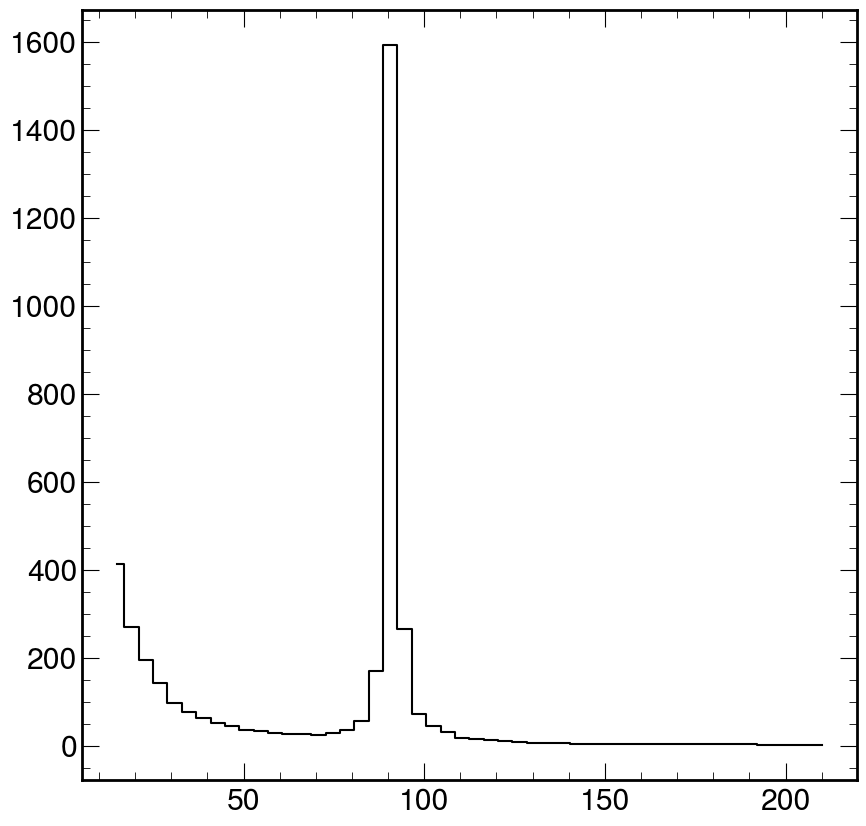

In [24]:
num_bins = 50
interpolacao = interp1d(energias, secoes_de_choque, kind='linear')

# Crie novos pontos interpolados
energias_interp = np.linspace(energias.min(), energias.max(), num_bins)
secoes_de_choque_interp = interpolacao(energias_interp)

# Plot com mais bins
plt.step(energias_interp, secoes_de_choque_interp, where='mid', color='black',label='_nolegend_')

# Criando um retângulo vazio para a legenda
empty_rectangle = Rectangle((0, 0), 1, 1, fill=False, edgecolor='black', linewidth=1)

# Adicionando o retângulo à legenda
plt.gca().add_artist(empty_rectangle)

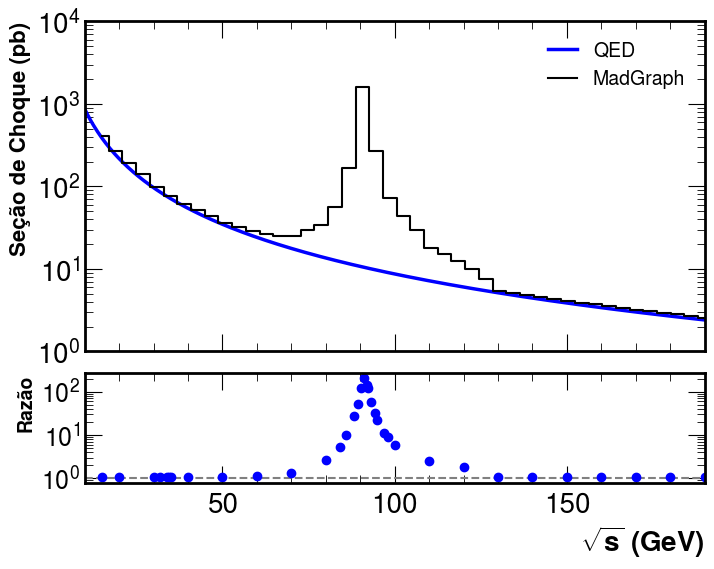

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)



ax1.plot(s_values, funcao_qed, label='QED', color='blue', linewidth=2.5)



ax1.step(energias_interp, secoes_de_choque_interp, where='mid', color='black',label='MadGraph')

# Adiciona as barras de erro verticais
for i in range(len(energias)):
    ax1.plot([energias[i], energias[i]], [secoes_de_choque[i] - erros_associados[i], secoes_de_choque[i] + erros_associados[i]], color='black', linewidth=2)  # Barras de erro verticais


hep.style.use('CMS')
# Títulos e configurações do gráfico principal
#ax1.set_title('Seção de Choque para e+e- \u2192 $\mathbf{\gamma}$  \u2192 μ+μ-', fontsize=18, weight='bold')
#ax1.set_xlabel(r'$\mathbf{\sqrt{s}}$ (GeV)', fontsize=24, weight='bold')
ax1.set_ylabel('Seção de Choque (pb)', fontsize=16, weight='bold')

# Configurando escala logarítmica e limites apenas para o gráfico principal
ax1.set_yscale('log')
ax1.set_ylim(1, 1e4)
ax1.set_xlim(10, 190)
ax1.legend(fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=20)

# Ratio plot no subplot ax2

ax2.errorbar(energias, razao_qed, fmt='o', color='blue', elinewidth=2, capsize=5)  # Removido o label
#ax2.errorbar(energias, compatibilidade_qed, fmt='o', color='blue', elinewidth=2, capsize=5, label='Compatibilidade')
ax2.set_xlabel(r'$\mathbf{\sqrt{s}}$ (GeV)', fontsize=20, weight='bold')
ax2.set_ylabel('Razão', fontsize=14, weight='bold')
ax2.axhline(1, color='gray', linestyle='--')  # Linha horizontal em y = 1 para referência

# Configurações do ratio plot (sem escala logarítmica ou limites definidos)
ax2.set_yscale('log')
ax2.set_xlim(10, 190)  
#ax2.set_ylim(0.8, 1.2)


ax2.tick_params(axis='x', which='major', labelsize=20)
ax2.tick_params(axis='y', which='major', labelsize=18)
#ax2.grid(True)

# Ajustando o layout para eliminar espaçamento entre os gráficos
plt.subplots_adjust(hspace=0.1)  # Define o espaçamento vertical entre os subplots
#plt.tight_layout()
# Salvando como uma única imagem
#plt.savefig('aa.png')  
#plt.show()  # Exibe os gráficos

#print(razao_qed)

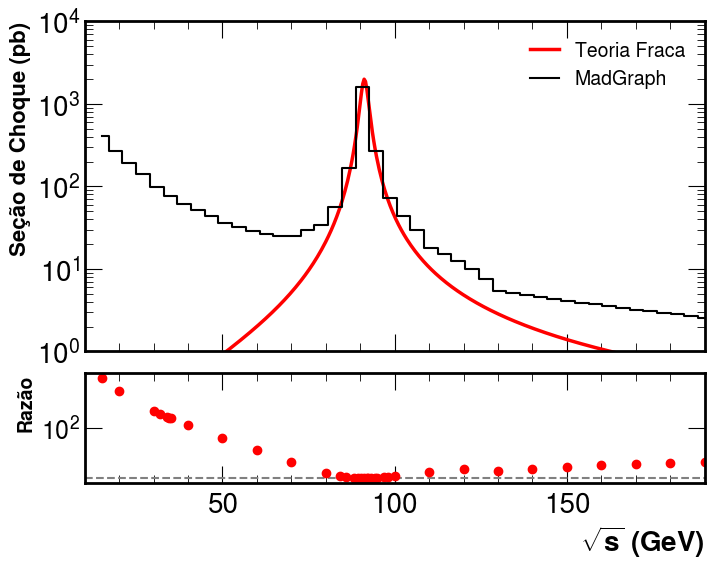

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)



ax1.plot(s_values, funcao_fraca, label='Teoria Fraca', color='red', linewidth=2.5)



ax1.step(energias_interp, secoes_de_choque_interp, where='mid', color='black',label='MadGraph')

# Adiciona as barras de erro verticais
for i in range(len(energias)):
    ax1.plot([energias[i], energias[i]], [secoes_de_choque[i] - erros_associados[i], secoes_de_choque[i] + erros_associados[i]], color='black', linewidth=2)  # Barras de erro verticais


hep.style.use('CMS')

ax1.set_ylabel('Seção de Choque (pb)', fontsize=16, weight='bold')

# Configurando escala logarítmica e limites apenas para o gráfico principal
ax1.set_yscale('log')
ax1.set_ylim(1, 1e4)
ax1.set_xlim(10, 190)
ax1.legend(fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=20)

# Ratio plot no subplot ax2

ax2.errorbar(energias, razao_fraca, fmt='o', color='red', elinewidth=2, capsize=5)  # Removido o label

ax2.set_xlabel(r'$\mathbf{\sqrt{s}}$ (GeV)', fontsize=20, weight='bold')
ax2.set_ylabel('Razão', fontsize=14, weight='bold')
ax2.axhline(1, color='gray', linestyle='--')  # Linha horizontal em y = 1 para referência

# Configurações do ratio plot (sem escala logarítmica ou limites definidos)
ax2.set_yscale('log')
#ax2.set_xlim(80, 100)  
#ax2.set_ylim(0.8, 1.2)


ax2.tick_params(axis='x', which='major', labelsize=20)
ax2.tick_params(axis='y', which='major', labelsize=18)



plt.subplots_adjust(hspace=0.1)  



#plt.savefig('bb.png')  
#plt.show()  

#print(razao_qed)

In [27]:
#CERN-LEP. Final analysis of the hadronic and leptonic total cross sections and the leptonic forward-backward asymmetries around the Z0 using the full LEPI data sample of 161 pb-1 integrated luminosity with 4.5 million selected Z0 decays. The results are in good agreement with lepton universality and consistent with the vector and axial-vector couplings predicted by the standard model. A fit of the complete data set yields the following Z0 resonance parameters:. Z0 mass = 91.1852 +- 0.0030 GeV. Z0 width = 2.4948 +- 0.0041 GeV. SIG0(C=HAD) = 41.501 +- 0.055 MB. R(C=L) = 20.823 +- 0.044. ASYM(NAME=FB,C=O,L) = 0.0145 +- 0.0017. WIDTH(C=INVIS)/WIDTH(C=2LEPTON) = 5.942 +- 0.027.

energias_OPAL = np.array([88.251, 89.251, 90.249, 91.244, 92.235, 93.238, 94.235, 91.254, 88.481, 
                         89.472, 90.227, 91.223, 91.969, 92.968, 93.717, 91.299, 89.4505, 91.2072, 
                         93.0351, 91.22, 91.4286, 91.2195, 89.4415, 91.2827, 92.9715])
secoes_de_choque_OPAL = np.array([
    [0.2449, 0.0243], [0.4178, 0.0284], [0.8427, 0.0477], [1.4854, 0.0221], 
    [1.0838, 0.0477], [0.5958, 0.0345], [0.3969, 0.0284], [1.4869, 0.0182], 
    [0.2318, 0.0202], [0.5167, 0.0273], [0.9078, 0.0353], [1.4877, 0.0232], 
    [1.2448, 0.0424], [0.6833, 0.0354], [0.4792, 0.0242], [1.4802, 0.0083], 
    [0.4959, 0.0081], [1.4589, 0.0142], [0.6677, 0.0091], [1.4778, 0.0058], 
    [1.4808, 0.0674], [1.4787, 0.0272], [0.4907, 0.0081], [1.5111, 0.0193], 
    [0.6889, 0.0093]
])

secoes_de_choque_OPAL = secoes_de_choque_OPAL*1e3


#CERN-LEP. Study of leptonic decays of the Z0 boson by the DELPHI Collaboration.

energias_DELPHI_1 = np.array([88.28, 89.28, 90.28, 91.04, 91.28, 91.54, 92.29])

secoes_de_choque_DELPHI_1 = np.array([
    [0.13, 0.06],
    [0.24, 0.09],
    [0.35, 0.09],
    [0.72, 0.13],
    [0.8,  0.14],
    [0.9,  0.11],
    [0.5,  0.14],

])
secoes_de_choque_DELPHI_1=secoes_de_choque_DELPHI_1 *2.2*1e3




energias_DELPHI = energias_DELPHI_1
secoes_de_choque_DELPHI = secoes_de_choque_DELPHI_1






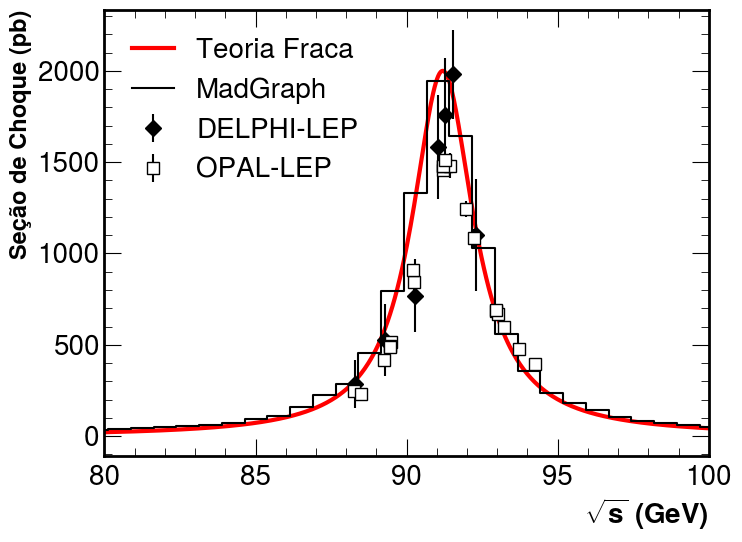

In [28]:
plt.figure(figsize=(8,6))


hep.style.use('CMS')
s_values = np.linspace(1, 200, 5000)
#função 2
funcao_fraca = weak(s_values) * GeV_to_pb
plt.plot(s_values, funcao_fraca, label='Teoria Fraca', linewidth=3, color = 'red')


num_bins = 260
interpolacao = interp1d(energias, secoes_de_choque, kind='linear')

# Crie novos pontos interpolados
energias_interp = np.linspace(energias.min(), energias.max(), num_bins)
secoes_de_choque_interp = interpolacao(energias_interp)

# Plot com mais bins
plt.step(energias_interp, secoes_de_choque_interp, where='mid', color='black',label='MadGraph')


#DELPHI 
plt.errorbar(energias_DELPHI, secoes_de_choque_DELPHI[:, 0], yerr=secoes_de_choque_DELPHI[0:,1], fmt='D', color='black', label='DELPHI-LEP', capsize=0, ms=8)

#OPAL
plt.errorbar(energias_OPAL, secoes_de_choque_OPAL[:, 0], yerr=secoes_de_choque_OPAL[0:,1], fmt='s', color='black',mfc='white', label='OPAL-LEP', capsize=0, ms=8)             





plt.xlabel(r'$\mathbf{\sqrt{s}}$ (GeV)', fontsize=20, weight='bold')
plt.ylabel('Seção de Choque (pb)', fontsize=17,weight='bold')



plt.legend(fontsize=20)

#plt.yscale('log')
#plt.ylim(1e1,1e5)
plt.xlim(80,100)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout() 

#plt.savefig('hist_exp_dados_fraco.png')
plt.show()



<ErrorbarContainer object of 3 artists>

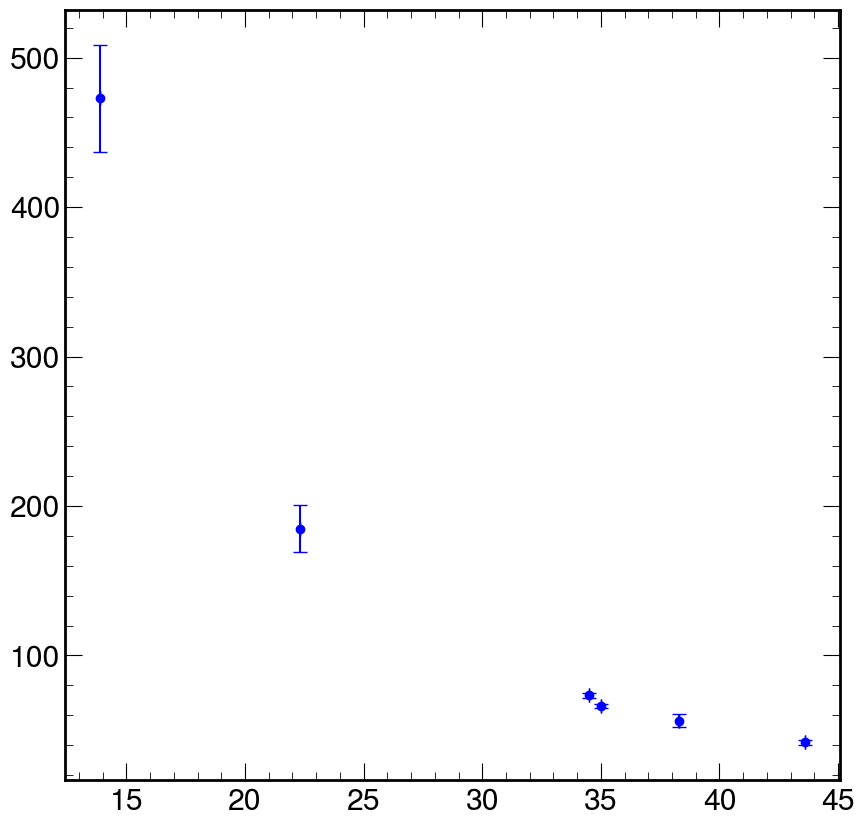

In [29]:
s = np.array([13.9, 22.3, 34.5, 35.0, 38.3, 43.6])  # sqrt(S) [GeV]
s_1 = np.array([472.7, 184.7, 73.2, 66.1, 56.4, 42.0])  # SIG [PB]

stat_errors = np.array([36.0, 15.7, 1.5, 1.3, 4.4, 1.7])  # Erros estatísticos

# Plot
plt.errorbar(s, s_1, xerr=0, yerr=stat_errors, fmt='o', 
             label="TASSO", capsize=5, linestyle='none', color='blue')



In [30]:
energias_CELLO_1 = np.array([38.3, 41.3, 43.6, 44.2, 46.2])
secoes_de_choque_CELLO_1 = np.array([
    [57.4, 4.2],
    [54.1, 8.9],
    [44.1, 3.3],
    [44.7, 4.0],
    [38.9, 8.9]
])



#DESY-PETRA. Measurement of E+ E- --& gt; MU+ MU- for sqrt(s) from 14 to 36.4 Gev by the CELLO collaboration. Behrend et al., ZP C16(1983)301 gives analysis of same data but combined with TAU+ TAU- data, and PL 140B(1984)130 gives data at higher energy. Data are radiative corrected.
energias_CELLO_2= np.array([14.0,  25.0, 33.3, 34.0, 34.7, 36.4])

secoes_de_choque_CELLO_2 = np.array([
    [516.0, 41.0],

    [131.7, 38.0],
    [81.2, 11.8],
    [64.6, 4.7],
    [79.9, 15.5],
    [53.0, 18.4]
])

energias_CELLO = np.concatenate((energias_CELLO_1, energias_CELLO_2))
secoes_de_choque_CELLO = np.concatenate((secoes_de_choque_CELLO_1, secoes_de_choque_CELLO_2))


In [31]:
#KEK-TRISTAN. Measurement of cross sections and asymmetries for mu+ mu- and tau+ tau- production in e+ e- annihilation at sqrt(s) = 52 to 61.4 GeV by the TOPAZ Collaboration.. This analysis includes data from the previous publication, Adachi et al., 1988, PL 208B,319 (& lt;a href=http://durpdg.dur.ac.uk/scripts/reacsearch.csh/TESTREAC/red+1486& gt; RED = 1486 & lt;/a& gt;).
energias_TOPAZ = np.array([
    52.0,

    55.0,

    57.0,
    58.0,

    60.0,
    60.8,

])

secoes_de_choque_TOPAZ= np.array([
    [33.5, 4.6],  # [valor, erro estatístico]

    [27.1, 4.5],

    [21.7, 3.8],
    [25.1, 1.0],
 
    [28.3, 4.5],
    [28.3, 4.2],

])

In [32]:
energias_AMY = np.array([52.0, 55.0, 56.0, 57.0])

secoes_de_choque_AMY= np.array([
    [33.5, 4.7],
    [23.5, 3.9],
    [30.9, 3.5],
    [30.8, 3.8]  # Erro não especificado para 30.8, pode ser tratado como 0
])



In [33]:
#Analise dos dados e Compatibilidade
teoria_fraca = weak(energias)*GeV_to_pb
teoria_qed = qed(energias)*GeV_to_pb
teoria_total = total(energias)*GeV_to_pb

razao_fraca = (teoria_fraca/secoes_de_choque)**-1
razao_qed = (teoria_qed/secoes_de_choque)**-1
razao_total = (teoria_total/secoes_de_choque)**-1

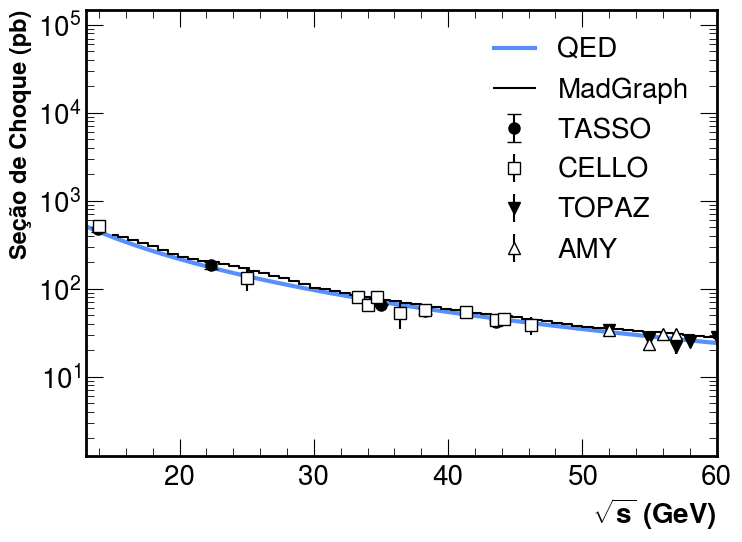

In [34]:
plt.figure(figsize=(8,6))


hep.style.use('CMS')
s_values = np.linspace(1, 70, 500)  # de 1 a 50 GeV^2


#função 1
funcao_qed = qed(s_values) * GeV_to_pb
plt.plot(s_values, funcao_qed, label='QED', linewidth=3)


plt.step(energias_interp, secoes_de_choque_interp, where='mid', color='black',label='MadGraph')




#PETRA
plt.errorbar(s, s_1,yerr=stat_errors, fmt='o',label="TASSO", capsize=5, color='black',ms=8)
plt.errorbar(energias_CELLO, secoes_de_choque_CELLO[:, 0], yerr=secoes_de_choque_CELLO[0:,1], fmt='s', color='black', label='CELLO', capsize=0,mfc='white', mec='black', ms=8)


#KEK
plt.errorbar(energias_TOPAZ, secoes_de_choque_TOPAZ[:, 0], yerr=secoes_de_choque_TOPAZ[0:,1], fmt='v', color='black', label='TOPAZ', capsize=0, mfc='black', mec='black', ms=8)
plt.errorbar(energias_AMY, secoes_de_choque_AMY[:, 0], yerr=secoes_de_choque_AMY[0:,1], fmt='^', color='black', label='AMY', capsize=0,mfc='white', ms=8)


plt.xlabel(r'$\mathbf{\sqrt{s}}$ (GeV)', fontsize=20, weight='bold')
plt.ylabel('Seção de Choque (pb)', fontsize=17,weight='bold')



plt.legend(fontsize=20)

plt.yscale('log')
#plt.ylim(1e1,1e5)
plt.xlim(13,60)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout() 

#plt.savefig('hist_exp_dados.png', dpi=400)
plt.show()

